# Validation of Analytical Porous Electrode Model with Physics-Based Modeling and Data Science Approach

In [1]:
## editing system path to enable the load of nleis.py
import os.path
import sys
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory by moving up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [2]:
### basic package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### import nleis.py

from nleis import EISandNLEIS
from nleis.visualization import plot_first,plot_second


### formatting package

from tqdm import tqdm
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")



In [3]:
input_parameters = pd.read_table('model_runs_512_10239.txt', delimiter=',')
p=input_parameters

In [4]:
input_parameters

,run,l_neg[m],l_sep[m],l_pos[m],Rp_neg[m],Rp_pos[m],epsilon_f_neg[1],epsilon_f_pos[1],epsilon_neg[1],epsilon_sep[1],...,tP[1],aa_neg[1],aa_pos[1],kappa_0[S/m],sigma_neg[S/m],sigma_pos[S/m],dUdcp_neg[V*cm^3/mol],dUdcp_pos[V*cm^3/mol],d2Udcp2_neg[V*cm^6/mol^2],d2Udcp2_pos[V*cm^6/mol^2]
0,1,0.000428,0.000020,0.000712,0.000007,0.000010,0.089316,0.062930,0.418434,0.782075,...,0.417455,0.347628,0.755187,5.349641,198.917694,4.969215,-20.707168,-7.650861,0.031034,-1723.582158
1,2,0.000428,0.000020,0.000712,0.000007,0.000010,0.084345,0.060970,0.412145,0.737694,...,0.922087,0.332836,0.769674,5.349641,198.917694,4.969215,-20.707168,-7.650861,-0.031034,-1723.582158
2,3,0.000428,0.000020,0.000712,0.000007,0.000010,0.089316,0.062930,0.418434,0.782075,...,0.417455,0.347628,0.755187,5.349641,198.917694,4.969215,-20.707168,-7.650861,0.031034,-1723.582158
3,4,0.000428,0.000020,0.000712,0.000007,0.000010,0.089316,0.062930,0.418434,0.782075,...,0.417455,0.347628,0.755187,5.349641,198.917694,4.969215,-20.707168,-7.650861,0.031034,-1723.582158
4,5,0.000428,0.000020,0.000712,0.000007,0.000010,0.089316,0.062930,0.418434,0.782075,...,0.417455,0.347628,0.755187,5.349641,198.917694,4.969215,-20.707168,-7.650861,0.031034,-1723.582158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,10235,0.000930,0.000037,0.000779,0.000009,0.000004,0.108458,0.045856,0.253529,0.654332,...,0.843413,0.665614,0.275023,0.161413,2064.184982,54.451537,-71.505870,-0.044119,7.142825,-42.414701
10235,10236,0.000930,0.000037,0.000779,0.000009,0.000004,0.108458,0.045856,0.253529,0.654332,...,0.843413,0.665614,0.275023,0.161413,2064.184982,54.451537,-0.016880,-8.930367,59380.083886,-4.051286
10236,10237,0.000930,0.000037,0.000779,0.000009,0.000004,0.108458,0.045856,0.253529,0.654332,...,0.843413,0.665614,0.275023,0.161413,2064.184982,54.451537,-0.016880,-8.930367,7.142825,-42.414701
10237,10238,0.000930,0.000037,0.000779,0.000009,0.000004,0.108458,0.045856,0.253529,0.654332,...,0.843413,0.665614,0.275023,4.570144,121.124797,21.823225,-0.016880,-8.930367,7.142825,-42.414701


In [5]:
## definition of cost function
def cost_seq(data,model):
    Max = max(abs(data))
    data = data/Max
    model = model/Max
    sum1 = np.sum((data.real-model.real)**2)
    sum2 = np.sum((data.imag-model.imag)**2)
    return(sum1+sum2)

## Direct Comparision

In [6]:
def direct_no_fit(filename,p):
    F = 96485.3321233100184
    f=F/(8.31446261815324*298)
    brugg = 4 
    sigma_eff_pos = p['sigma_pos[S/m]']*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]'])**brugg ## S/m
    sigma_eff_neg = p['sigma_neg[S/m]']*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]'])**brugg ## S/m
    keff_c = p['kappa_0[S/m]']*p['epsilon_pos[1]']**brugg ## S/m
    keff_a = p['kappa_0[S/m]']*p['epsilon_neg[1]']**brugg ## S/m
    keff_sep = p['kappa_0[S/m]']**p['epsilon_sep[1]']**brugg ## S/m

    a_cathode = (3/p['Rp_pos[m]'])*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]']) ## 1/m
    a_anode = (3/p['Rp_neg[m]'])*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]']) ## 1/m
    area_factor_cathode = a_cathode*p['l_pos[m]'] ## unitless
    area_factor_anode = a_anode*p['l_neg[m]'] ## unitless
    
    R0= p['l_pos[m]']/(sigma_eff_pos+keff_c)+(p['l_sep[m]']/keff_sep)+p['l_neg[m]']/(sigma_eff_neg+keff_a)
   
    R_c = (1/(p['i0_pos[A/m^2]']*f))/area_factor_cathode ## ohms * m^2
    R_a = (1/(p['i0_neg[A/m^2]']*f))/area_factor_anode ## ohms * m^2
    Cdl_c = area_factor_cathode*((p['Cdl_pos[uF/cm^2]']/(10**6))*10**4) ## F/m^2
    Cdl_a = area_factor_anode*((p['Cdl_neg[uF/cm^2]']/(10**6))*10**4) ## F/m^2

    Rp_c = p['l_pos[m]']/keff_c ## Ohms * m^2
    Rp_a = p['l_neg[m]']/keff_a ## Ohms * m^2

    tau_c = ((p['Rp_pos[m]']**2)/p['Ds_pos[m^2/s]']) ## s
    tau_a = ((p['Rp_neg[m]']**2)/p['Ds_neg[m^2/s]']) ## s
    Aw_c = (-p['dUdcp_pos[V*cm^3/mol]']*10**(-6)*(p['Rp_pos[m]'])/(F*p['Ds_pos[m^2/s]']))/area_factor_cathode ## Ohms * m^2
    Aw_a = (-p['dUdcp_neg[V*cm^3/mol]']*10**(-6)*(p['Rp_neg[m]'])/(F*p['Ds_neg[m^2/s]']))/area_factor_anode ## Ohms * m^2 
    k_c = p['d2Udcp2_pos[V*cm^6/mol^2]']/(2*p['dUdcp_pos[V*cm^3/mol]']**2) ## 1/V
    k_a = p['d2Udcp2_neg[V*cm^6/mol^2]']/(2*p['dUdcp_neg[V*cm^3/mol]']**2) ## 1/V
    e_c = p['aa_pos[1]']-0.5 ## unitless
    e_a = p['aa_neg[1]']-0.5 ## unitless

    initial_guess = np.hstack([R0,Rp_c,R_c,Cdl_c,Aw_c,tau_c,k_c,e_c,Rp_a,R_a,Cdl_a,Aw_a,tau_a,k_a,e_a])
    resitivity = np.hstack([sigma_eff_pos,sigma_eff_neg,keff_c,keff_a])
    ### initialize the EIS and NLEIS string
    ### inductor in series with a resistor, a spherical cathode, and a spherical anode
    circ_str_1 = 'R0-TDS0-TDS1' ## EIS string
    circ_str_2 = 'd(TDSn0,TDSn1)' ## NLEIS string 
    data = np.loadtxt(filename)
    frequencies_model = data[0]
    Z1s_model=data[1] - 1j*data[2]
    Z2s_model=data[3] - 1j*data[4]

    circuit = EISandNLEIS(circ_str_1,circ_str_2,initial_guess=initial_guess)
    Z1_fit,Z2_fit = circuit.predict(frequencies_model,max_f= np.inf)
    return Z1s_model,Z2s_model,Z1_fit,2*Z2_fit,initial_guess,resitivity
    

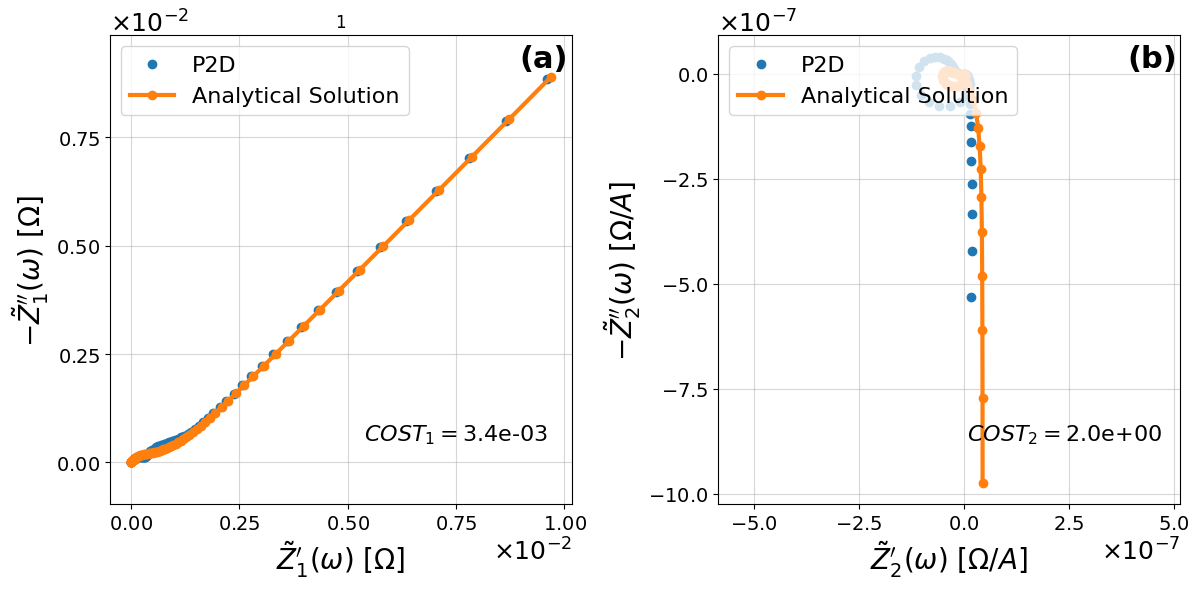

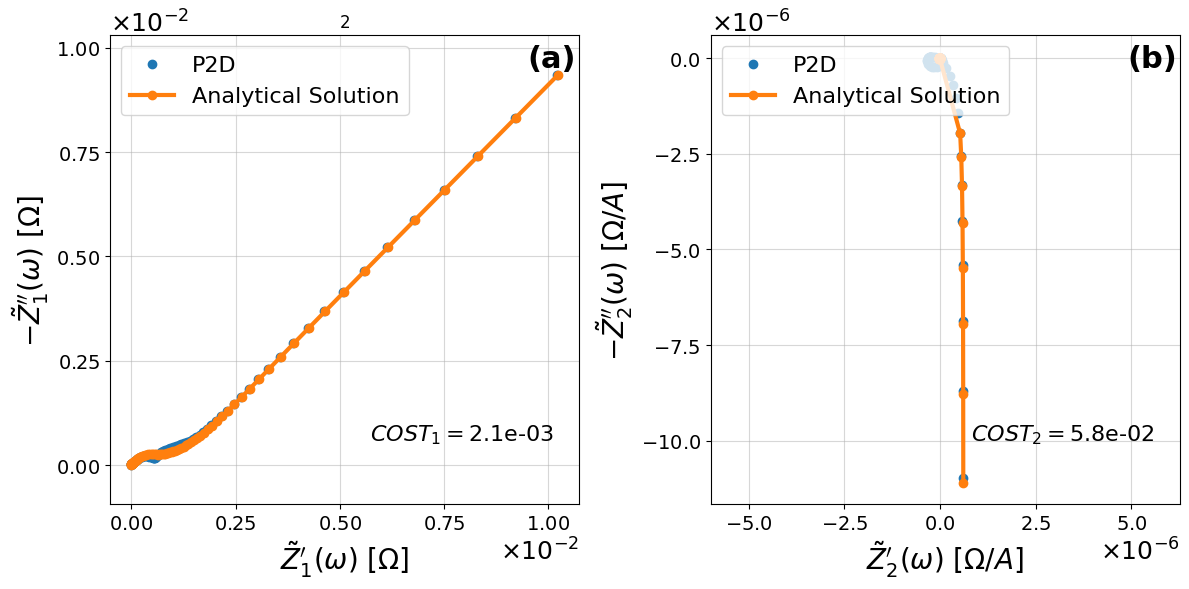

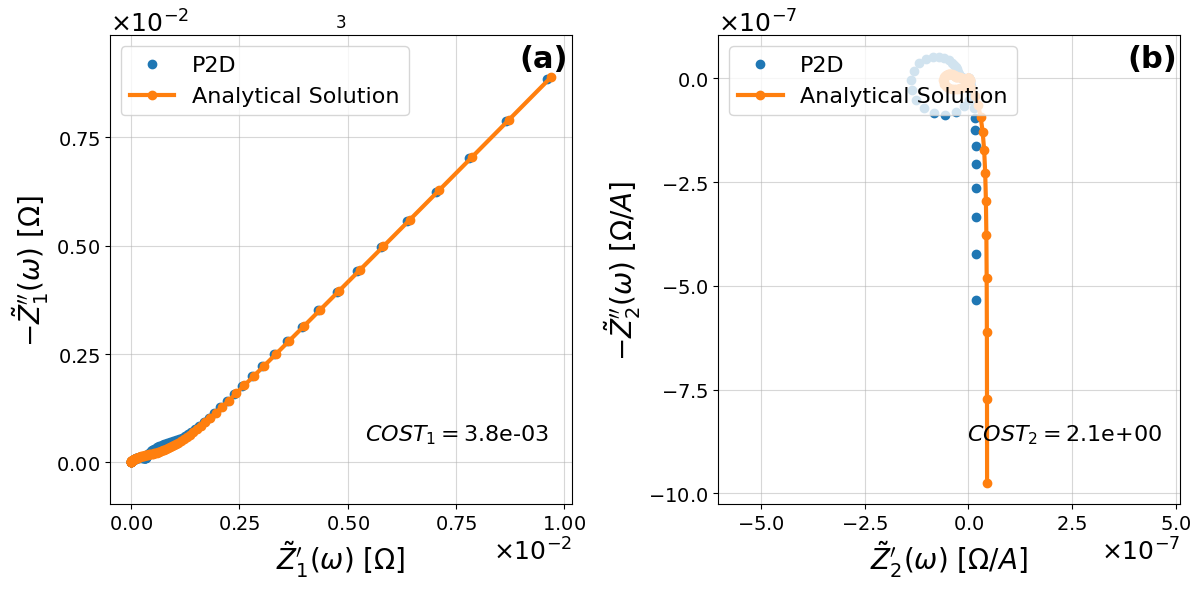

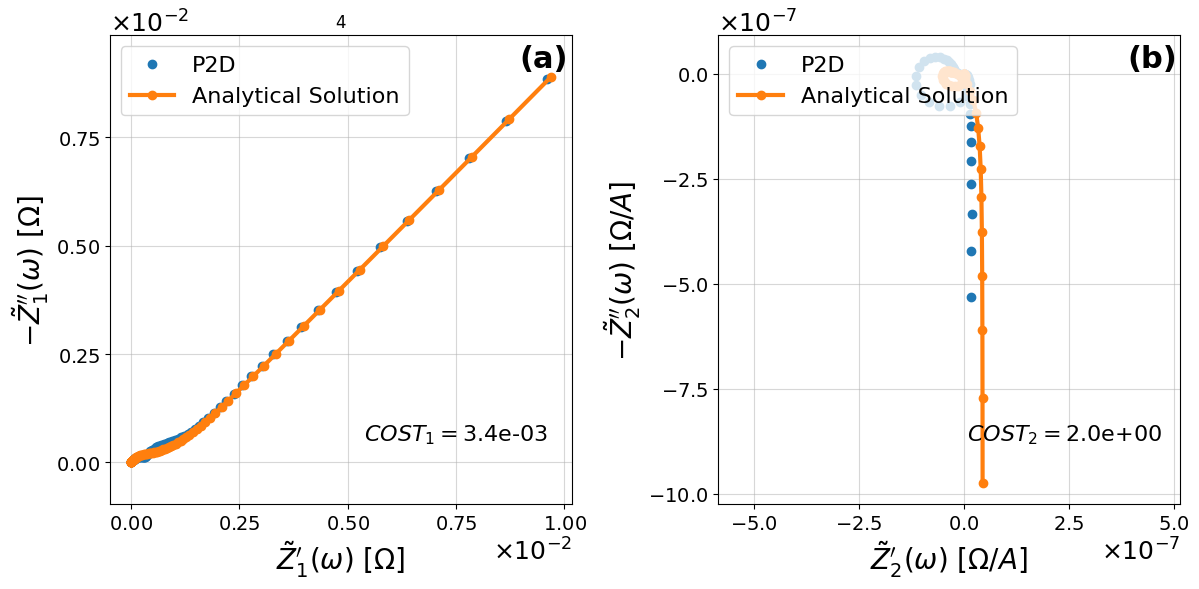

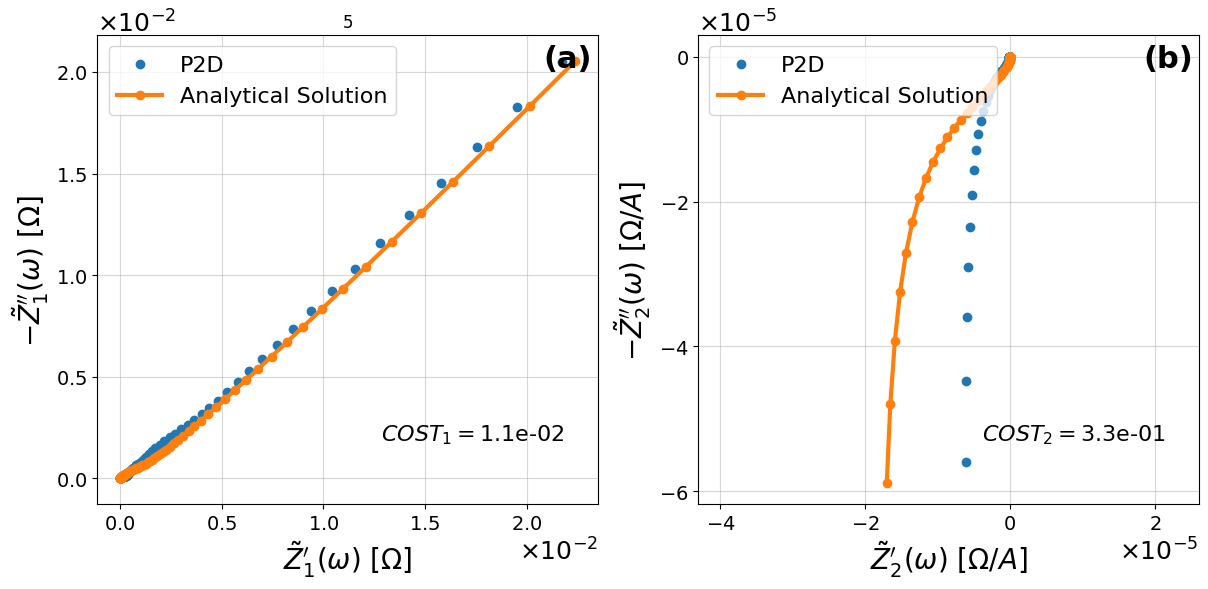

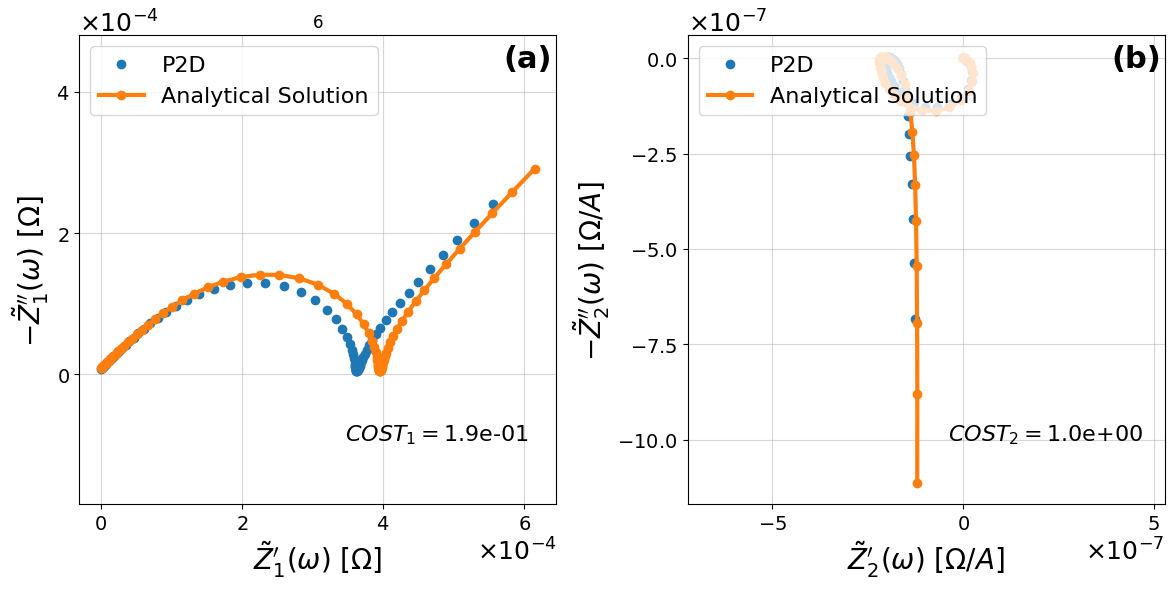

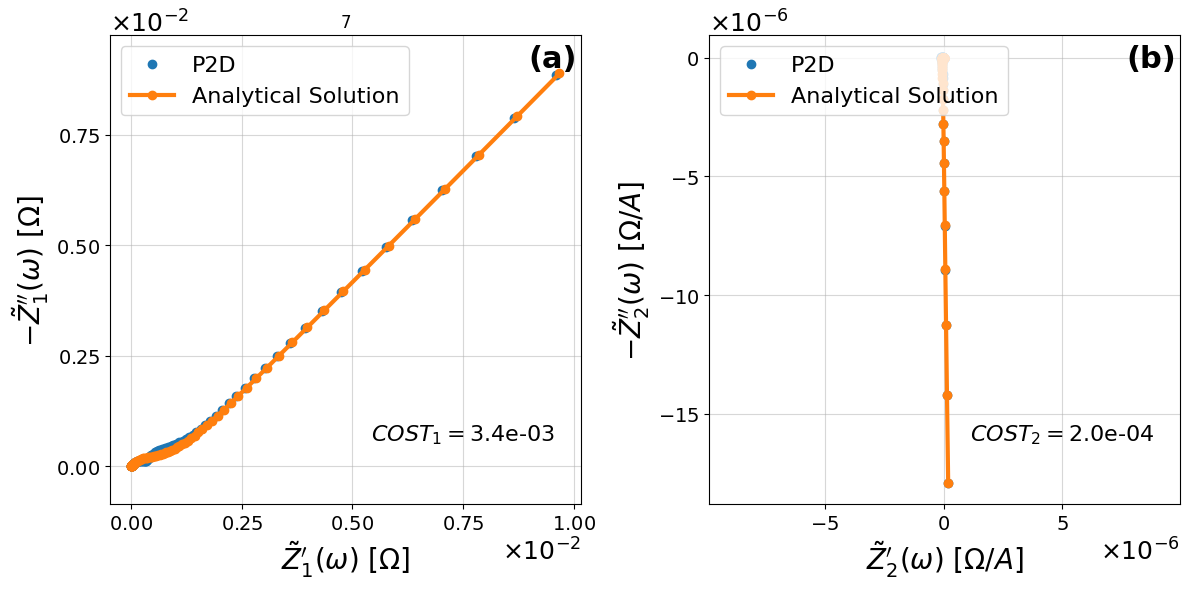

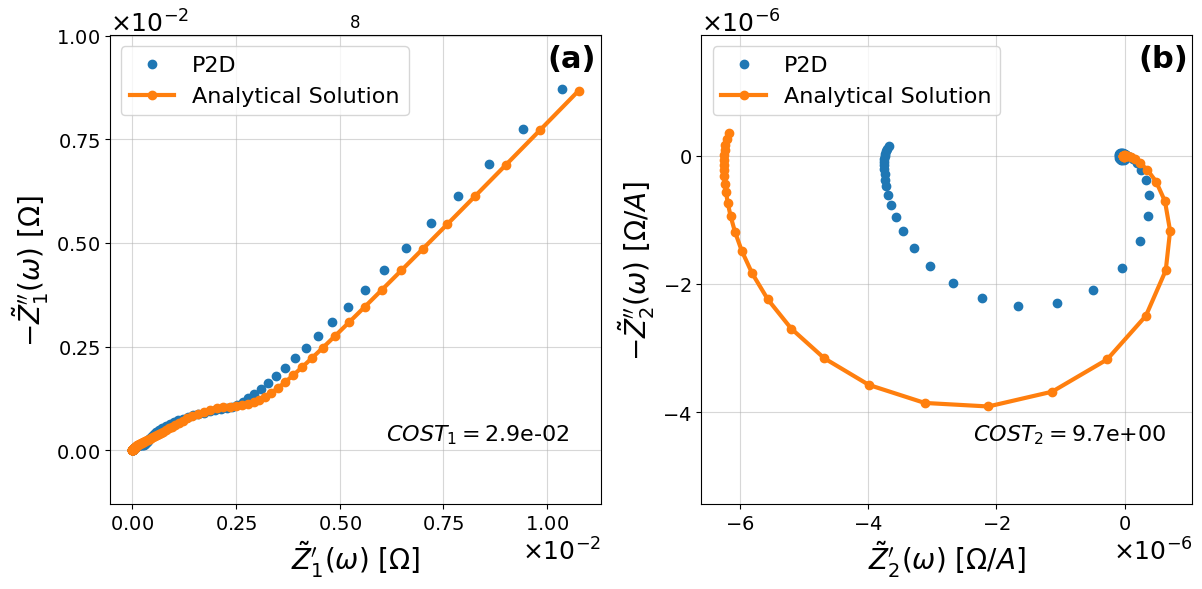

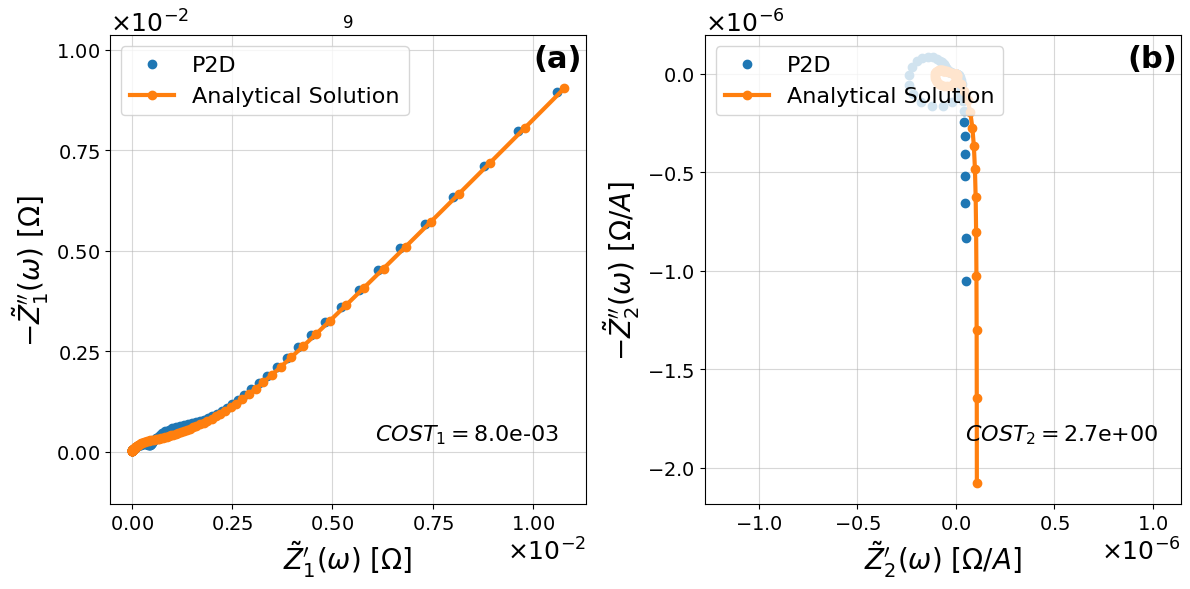

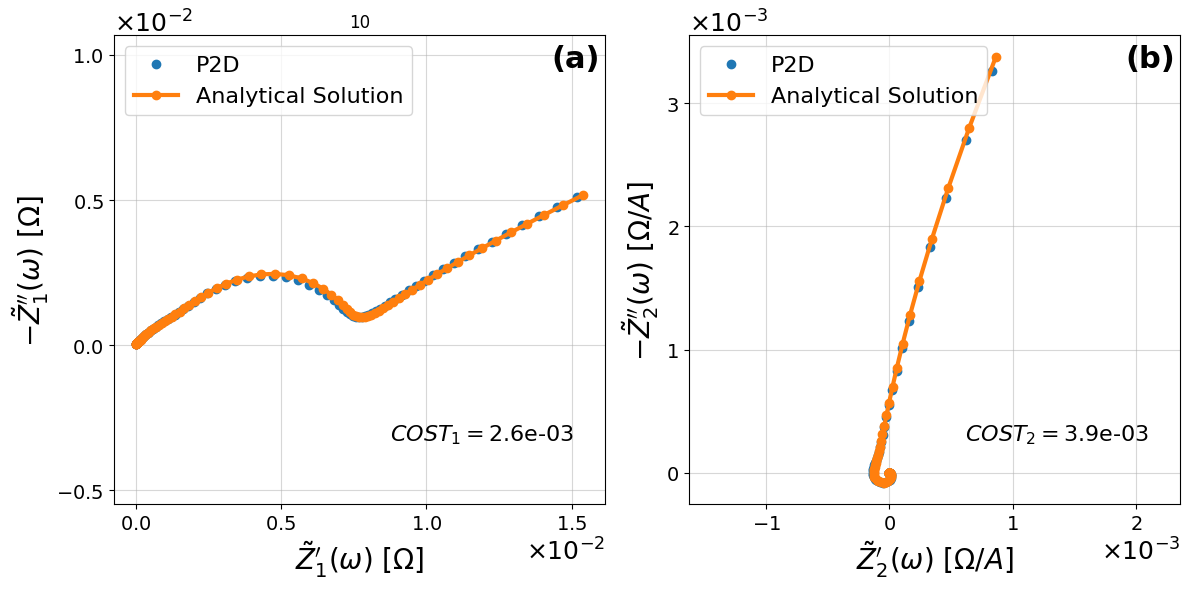

In [7]:
start = 0
# end = 10239
end = 10

cost_not_fit = []
p0_list = []
r_list = []
count = 0
bad_match_list = []
for i in range(start,end):
    if i in [401,403,2874,4249]:
        continue
    else:
        filename = 'data/run-'+str(i+1)+'.txt'
        p = input_parameters.iloc[i]
        
        Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= direct_no_fit(filename,p)
        p0_list.append(p0)
        r_list.append(r)
        Z1_data = Z1_data - Z1_data.real.min()
        Z1_fit = Z1_fit - Z1_fit.real.min()
        
        cost_not_fit.append(cost_seq(Z1_data,Z1_fit)+cost_seq(Z2_data,Z2_fit))
        
        
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        #### fresh cell plot
        ax[0].set_title(str(i+1))
        plot_first(ax[0],Z1_data, fmt='o',lw=3)
        plot_first(ax[0],Z1_fit, fmt='-o',lw=3)
        plot_second(ax[1],Z2_data, fmt='o',lw=3)
        plot_second(ax[1],Z2_fit, fmt='-o',lw=3)

        ax[0].legend(['P2D','Analytical Solution'],fontsize=16,loc='upper left')
        ax[1].legend(['P2D','Analytical Solution'],fontsize=16,loc='upper left')
        ax[0].text(0.75, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes,size=16)
        ax[0].text(0.94, 0.95, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes, size=22, weight='bold')
        ax[1].text(0.75, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1].transAxes,size=16)
        ax[1].text(0.94, 0.95, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[1].transAxes, size=22, weight='bold')
        if (cost_seq(Z1_data,Z1_fit)+cost_seq(Z2_data,Z2_fit))>1e-2:
            count += 1
            bad_match_list.append(i+1)
        plt.tight_layout()
        plt.show()
        # fig.savefig('raw_figure/run-'+str(i+1)+'.png',dpi=300,bbox_inches='tight')
    

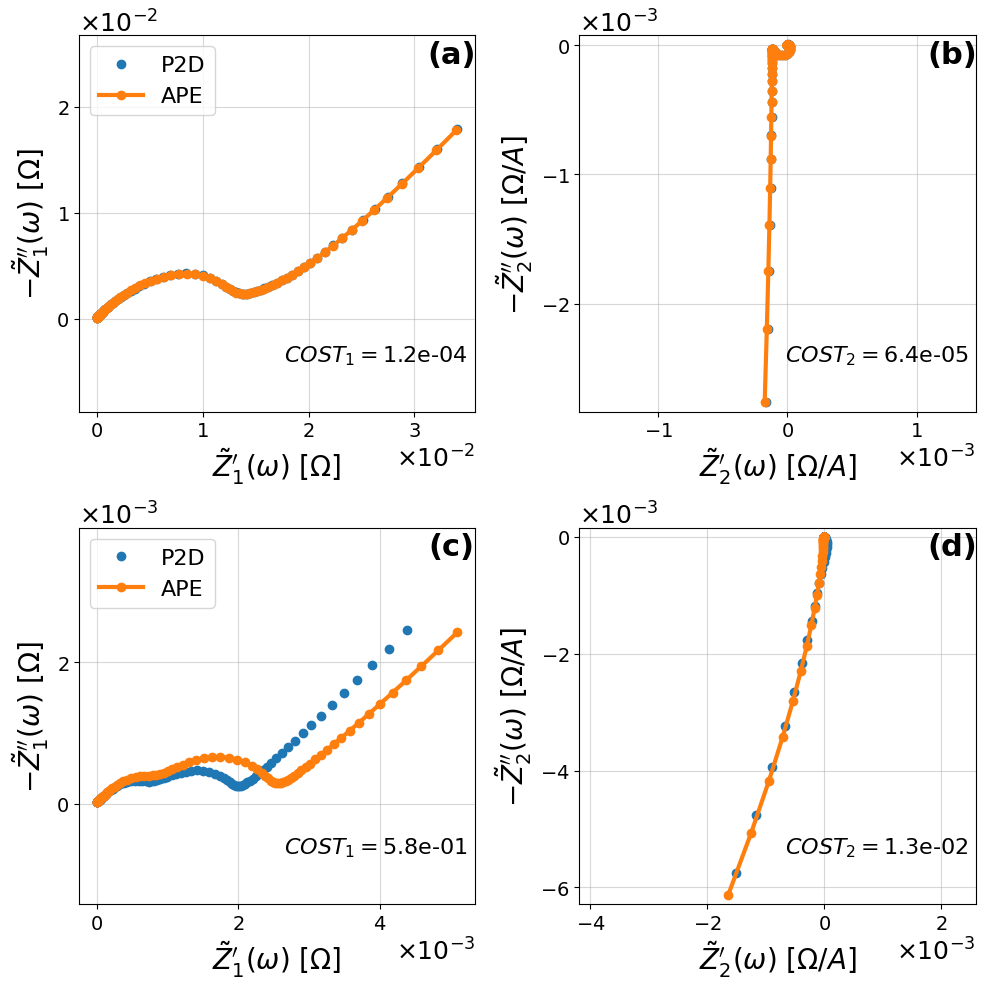

In [8]:
n = 80
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= direct_no_fit(filename,p)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()

fig, ax = plt.subplots(2,2,figsize=(10,10))
#### fresh cell plot
plot_first(ax[0,0],Z1_data, fmt='o',lw=3)
plot_first(ax[0,0],Z1_fit, fmt='-o',lw=3)
plot_second(ax[0,1],Z2_data, fmt='o',lw=3)
plot_second(ax[0,1],Z2_fit, fmt='-o',lw=3)


ax[0,0].legend(['P2D','APE'],fontsize=16,loc='upper left')
ax[0,0].text(0.75, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes,size=16)
ax[0,0].text(0.94, 0.95, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes, size=22, weight='bold')
ax[0,1].text(0.75, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes,size=16)
ax[0,1].text(0.94, 0.95, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes, size=22, weight='bold')

n = 11
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= direct_no_fit(filename,p)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()

plot_first(ax[1,0],Z1_data, fmt='o',lw=3)
plot_first(ax[1,0],Z1_fit, fmt='-o',lw=3)
plot_second(ax[1,1],Z2_data, fmt='o',lw=3)
plot_second(ax[1,1],Z2_fit, fmt='-o',lw=3)


ax[1,0].legend(['P2D','APE'],fontsize=16,loc='upper left')
ax[1,0].text(0.75, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes,size=16)
ax[1,0].text(0.94, 0.95, '(c)',horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes, size=22, weight='bold')
ax[1,1].text(0.75, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes,size=16)
ax[1,1].text(0.94, 0.95, '(d)',horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes, size=22, weight='bold')


plt.tight_layout()
plt.show()
# fig.savefig('general_figure/figure3.1.png',dpi=300,bbox_inches='tight')

## Curve Fitting Analysis 

In [20]:
def curve_fit(filename,p):
    F = 96485.3321233100184
    f=F/(8.31446261815324*298)
    brugg = 4 
    sigma_eff_pos = p['sigma_pos[S/m]']*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]'])**brugg ## S/m
    sigma_eff_neg = p['sigma_neg[S/m]']*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]'])**brugg ## S/m
    keff_c = p['kappa_0[S/m]']*p['epsilon_pos[1]']**brugg ## S/m
    keff_a = p['kappa_0[S/m]']*p['epsilon_neg[1]']**brugg ## S/m
    keff_sep = p['kappa_0[S/m]']**p['epsilon_sep[1]']**brugg ## S/m

    a_cathode = (3/p['Rp_pos[m]'])*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]']) ## 1/m
    a_anode = (3/p['Rp_neg[m]'])*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]']) ## 1/m
    area_factor_cathode = a_cathode*p['l_pos[m]'] ## unitless
    area_factor_anode = a_anode*p['l_neg[m]'] ## unitless
    
    R0= p['l_pos[m]']/(sigma_eff_pos+keff_c)+(p['l_sep[m]']/keff_sep)+p['l_neg[m]']/(sigma_eff_neg+keff_a)
   
    R_c = (1/(p['i0_pos[A/m^2]']*f))/area_factor_cathode ## ohms * m^2
    R_a = (1/(p['i0_neg[A/m^2]']*f))/area_factor_anode ## ohms * m^2
    Cdl_c = area_factor_cathode*((p['Cdl_pos[uF/cm^2]']/(10**6))*10**4) ## F/m^2
    Cdl_a = area_factor_anode*((p['Cdl_neg[uF/cm^2]']/(10**6))*10**4) ## F/m^2

    Rp_c = p['l_pos[m]']/keff_c ## Ohms * m^2
    Rp_a = p['l_neg[m]']/keff_a ## Ohms * m^2

    tau_c = ((p['Rp_pos[m]']**2)/p['Ds_pos[m^2/s]']) ## s
    tau_a = ((p['Rp_neg[m]']**2)/p['Ds_neg[m^2/s]']) ## s
    Aw_c = (-p['dUdcp_pos[V*cm^3/mol]']*10**(-6)*(p['Rp_pos[m]'])/(F*p['Ds_pos[m^2/s]']))/area_factor_cathode ## Ohms * m^2
    Aw_a = (-p['dUdcp_neg[V*cm^3/mol]']*10**(-6)*(p['Rp_neg[m]'])/(F*p['Ds_neg[m^2/s]']))/area_factor_anode ## Ohms * m^2 
    k_c = p['d2Udcp2_pos[V*cm^6/mol^2]']/(2*p['dUdcp_pos[V*cm^3/mol]']**2) ## 1/V
    k_a = p['d2Udcp2_neg[V*cm^6/mol^2]']/(2*p['dUdcp_neg[V*cm^3/mol]']**2) ## 1/V
    e_c = p['aa_pos[1]']-0.5 ## unitless
    e_a = p['aa_neg[1]']-0.5 ## unitless

    initial_guess = np.hstack([R0,Rp_c,R_c,Cdl_c,Aw_c,tau_c,k_c,e_c,Rp_a,R_a,Cdl_a,Aw_a,tau_a,k_a,e_a])
    ### initialize the EIS and NLEIS string
    ### inductor in series with a resistor, a spherical cathode, and a spherical anode    
    circ_str_1 = 'R0-TDS0-TDS1' ## EIS string
    circ_str_2 = 'd(TDSn0,TDSn1)' ## NLEIS string 
    data = np.loadtxt(filename)
    frequencies_model = data[0]
    Z1s_model=data[1] - 1j*data[2]
    Z2s_model=data[3] - 1j*data[4]

    circuit = EISandNLEIS(circ_str_1,circ_str_2,initial_guess=initial_guess)
    circuit.fit(frequencies_model,Z1s_model,Z2s_model/2,max_f=np.inf, opt='max');
    Z1_fit,Z2_fit = circuit.predict(frequencies_model,max_f= np.inf)
    p0 = circuit.parameters_
    return Z1s_model,Z2s_model,Z1_fit,2*Z2_fit,initial_guess,p0
    

[ 8.48192454e-05  1.00066230e-02  7.34504995e-06  1.58349691e+01
  7.16662110e-09  4.01793853e-01 -2.12686378e+03 -2.20272367e-01
  1.44029684e-04  6.02187593e-04  3.31859566e+00  2.62820001e-06
  9.74273455e+00  7.40552074e+02 -1.93601926e-01]


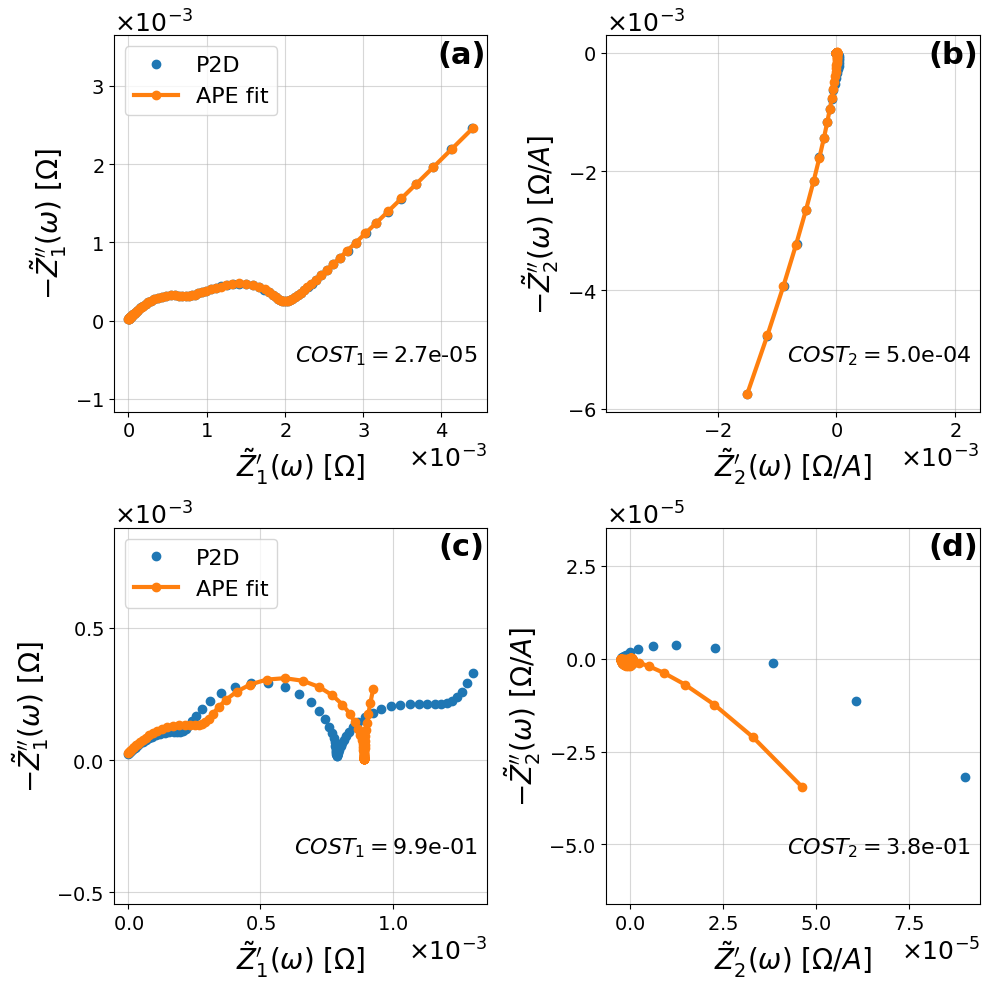

In [22]:
n = 11
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= curve_fit(filename,p)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()

fig, ax = plt.subplots(2,2,figsize=(10,10))
#### fresh cell plot
plot_first(ax[0,0],Z1_data, fmt='o',lw=3)
plot_first(ax[0,0],Z1_fit, fmt='-o',lw=3)
plot_second(ax[0,1],Z2_data, fmt='o',lw=3)
plot_second(ax[0,1],Z2_fit, fmt='-o',lw=3)

ax[0,0].legend(['P2D','APE fit'],fontsize=16,loc='upper left')

ax[0,0].text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes,size=16)
ax[0,0].text(0.93, 0.95, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes, size=22, weight='bold')
ax[0,1].text(0.73, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes,size=16)
ax[0,1].text(0.93, 0.95, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes, size=22, weight='bold')

n = 372
# n=80
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= curve_fit(filename,p)
print(r)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()

plot_first(ax[1,0],Z1_data, fmt='o',lw=3)
plot_first(ax[1,0],Z1_fit, fmt='-o',lw=3)
plot_second(ax[1,1],Z2_data, fmt='o',lw=3)
plot_second(ax[1,1],Z2_fit, fmt='-o',lw=3)


ax[1,0].legend(['P2D','APE fit'],fontsize=16,loc='upper left')

ax[1,0].text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes,size=16)
ax[1,0].text(0.93, 0.95, '(c)',horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes, size=22, weight='bold')
ax[1,1].text(0.73, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes,size=16)
ax[1,1].text(0.93, 0.95, '(d)',horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes, size=22, weight='bold')


plt.tight_layout()
plt.show()
# fig.savefig('general_figure/figure3.2.png',dpi=300,bbox_inches='tight')

## Curve fitting with noise

In [23]:
def curve_fit_noise(filename,p):
    F = 96485.3321233100184
    f=F/(8.31446261815324*298)
    brugg = 4 
    sigma_eff_pos = p['sigma_pos[S/m]']*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]'])**brugg ## S/m
    sigma_eff_neg = p['sigma_neg[S/m]']*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]'])**brugg ## S/m
    keff_c = p['kappa_0[S/m]']*p['epsilon_pos[1]']**brugg ## S/m
    keff_a = p['kappa_0[S/m]']*p['epsilon_neg[1]']**brugg ## S/m
    keff_sep = p['kappa_0[S/m]']**p['epsilon_sep[1]']**brugg ## S/m

    a_cathode = (3/p['Rp_pos[m]'])*(1-p['epsilon_f_pos[1]']-p['epsilon_pos[1]']) ## 1/m
    a_anode = (3/p['Rp_neg[m]'])*(1-p['epsilon_f_neg[1]']-p['epsilon_neg[1]']) ## 1/m
    area_factor_cathode = a_cathode*p['l_pos[m]'] ## unitless
    area_factor_anode = a_anode*p['l_neg[m]'] ## unitless
    
    R0= p['l_pos[m]']/(sigma_eff_pos+keff_c)+(p['l_sep[m]']/keff_sep)+p['l_neg[m]']/(sigma_eff_neg+keff_a)
   
    R_c = (1/(p['i0_pos[A/m^2]']*f))/area_factor_cathode ## ohms * m^2
    R_a = (1/(p['i0_neg[A/m^2]']*f))/area_factor_anode ## ohms * m^2
    Cdl_c = area_factor_cathode*((p['Cdl_pos[uF/cm^2]']/(10**6))*10**4) ## F/m^2
    Cdl_a = area_factor_anode*((p['Cdl_neg[uF/cm^2]']/(10**6))*10**4) ## F/m^2

    Rp_c = p['l_pos[m]']/keff_c ## Ohms * m^2
    Rp_a = p['l_neg[m]']/keff_a ## Ohms * m^2

    tau_c = ((p['Rp_pos[m]']**2)/p['Ds_pos[m^2/s]']) ## s
    tau_a = ((p['Rp_neg[m]']**2)/p['Ds_neg[m^2/s]']) ## s
    Aw_c = (-p['dUdcp_pos[V*cm^3/mol]']*10**(-6)*(p['Rp_pos[m]'])/(F*p['Ds_pos[m^2/s]']))/area_factor_cathode ## Ohms * m^2
    Aw_a = (-p['dUdcp_neg[V*cm^3/mol]']*10**(-6)*(p['Rp_neg[m]'])/(F*p['Ds_neg[m^2/s]']))/area_factor_anode ## Ohms * m^2 
    k_c = p['d2Udcp2_pos[V*cm^6/mol^2]']/(2*p['dUdcp_pos[V*cm^3/mol]']**2) ## 1/V
    k_a = p['d2Udcp2_neg[V*cm^6/mol^2]']/(2*p['dUdcp_neg[V*cm^3/mol]']**2) ## 1/V
    e_c = p['aa_pos[1]']-0.5 ## unitless
    e_a = p['aa_neg[1]']-0.5 ## unitless

    initial_guess = np.hstack([R0,Rp_c,R_c,Cdl_c,Aw_c,tau_c,k_c,e_c,Rp_a,R_a,Cdl_a,Aw_a,tau_a,k_a,e_a])
    ### initialize the EIS and NLEIS string
    ### inductor in series with a resistor, a spherical cathode, and a spherical anode    
    circ_str_1 = 'R0-TDS0-TDS1' ## EIS string
    circ_str_2 = 'd(TDSn0,TDSn1)' ## NLEIS string 
    data = np.loadtxt(filename)
    frequencies_model = data[0]
    Z1s_model=data[1]- 1j*data[2]
    Z2s_model=data[3] - 1j*data[4]

    ## Adding Noise

    factor = 0.05
    
    Z1_noise_real = np.random.normal(0, factor*Z1s_model.real, (Z1s_model.real).shape)
    Z1_noise_imag = np.random.normal(0, factor*abs(Z1s_model.imag), (Z1s_model.imag).shape)
    Z1_noise = Z1_noise_real + 1j*Z1_noise_imag
    
    Z2_noise_real = np.random.normal(0, factor*abs(Z2s_model.real), (Z2s_model.real).shape)
    Z2_noise_imag = np.random.normal(0, factor*abs(Z2s_model.imag), (Z2s_model.imag).shape)
    Z2_noise = Z2_noise_real + 1j*Z2_noise_imag
    
    Z1s_model = Z1s_model+Z1_noise
    Z2s_model = Z2s_model+Z2_noise

    circuit = EISandNLEIS(circ_str_1,circ_str_2,initial_guess=initial_guess)
    circuit.fit(frequencies_model,Z1s_model,Z2s_model/2,max_f=np.inf, opt='max');
    Z1_fit,Z2_fit = circuit.predict(frequencies_model,max_f= np.inf)
    p0 = circuit.parameters_
    return Z1s_model,Z2s_model,Z1_fit,2*Z2_fit,initial_guess,p0
    

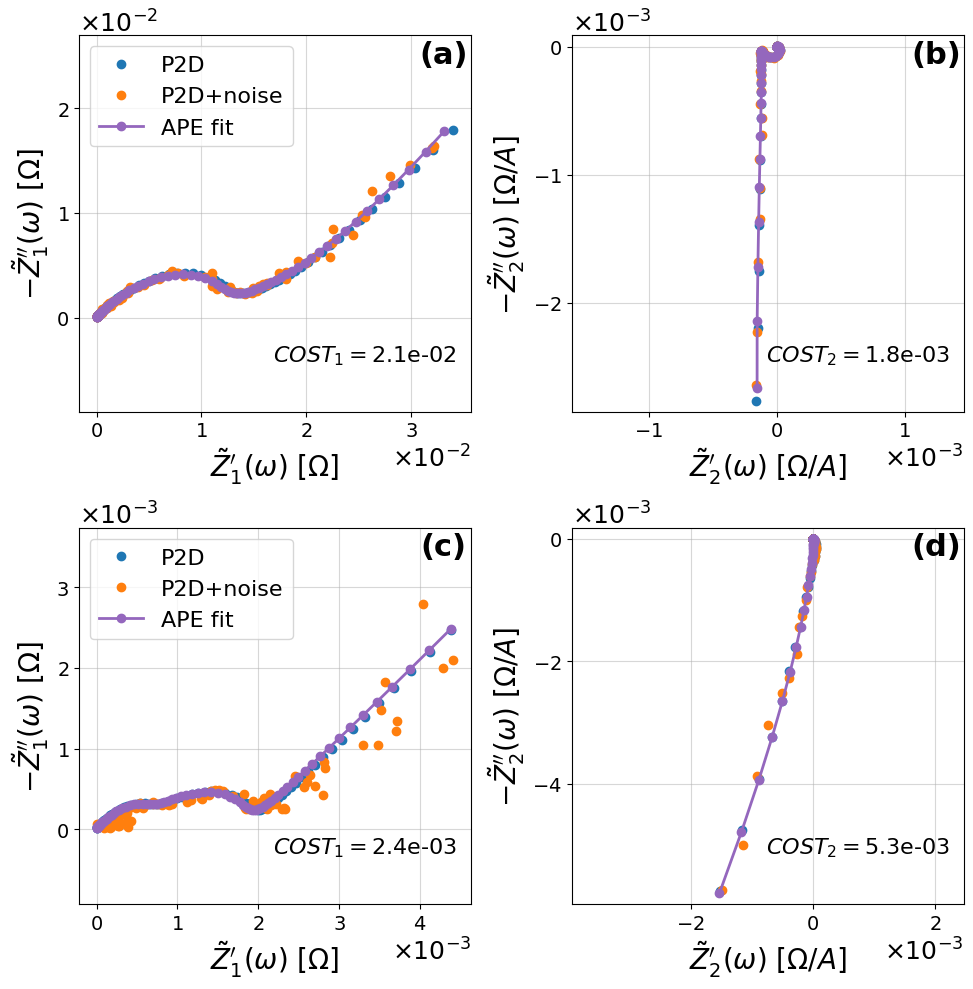

In [25]:
np.random.seed(0)

n = 80
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= curve_fit_noise(filename,p)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()
data = np.loadtxt(filename)
Z1=data[1]- 1j*data[2]
Z2=data[3] - 1j*data[4]

Z1= Z1 - Z1.real.min()


fig, ax = plt.subplots(2,2,figsize=(10,10))
#### fresh cell plot
plot_first(ax[0,0],Z1, fmt='o',lw=3)
plot_first(ax[0,0],Z1_data, fmt='o',lw=3)
plot_first(ax[0,0],Z1_fit, fmt='-o',lw=2,color = 'C4')

plot_second(ax[0,1],Z2, fmt='o',lw=3)
plot_second(ax[0,1],Z2_data, fmt='o',lw=3)
plot_second(ax[0,1],Z2_fit, fmt='-o',lw=2,color = 'C4')


ax[0,0].legend(['P2D','P2D+noise','APE fit'],fontsize=16,loc='upper left')
ax[0,0].text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1_data,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes,size=16)
ax[0,1].text(0.73, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes,size=16)

ax[0,0].text(0.93, 0.95, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0,0].transAxes, size=22, weight='bold')
ax[0,1].text(0.93, 0.95, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes, size=22, weight='bold')

n = 11
filename = 'data/run-'+str(n)+'.txt'
p = input_parameters.iloc[n-1]

Z1_data,Z2_data, Z1_fit,Z2_fit,p0,r= curve_fit_noise(filename,p)

Z1_data = Z1_data - Z1_data.real.min()
Z1_fit = Z1_fit - Z1_fit.real.min()
data = np.loadtxt(filename)
Z1=data[1]- 1j*data[2]
Z2=data[3] - 1j*data[4]

Z1= Z1 - Z1.real.min()

plot_first(ax[1,0],Z1, fmt='o',lw=3)
plot_first(ax[1,0],Z1_data, fmt='o',lw=3)
plot_first(ax[1,0],Z1_fit, fmt='-o',lw=2,color = 'C4')

plot_second(ax[1,1],Z2, fmt='o',lw=3)
plot_second(ax[1,1],Z2_data, fmt='o',lw=3)
plot_second(ax[1,1],Z2_fit, fmt='-o',lw=2,color = 'C4')


ax[1,0].legend(['P2D','P2D+noise','APE fit'],fontsize=16,loc='upper left')
ax[1,0].text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_seq(Z1,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes,size=16)

ax[1,1].text(0.73, 0.15, '$COST_{2} = $'+'{:0.1e}'.format(cost_seq(Z2_data,Z2_fit)), horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes,size=16)

ax[1,0].text(0.93, 0.95, '(c)',horizontalalignment='center',verticalalignment='center', transform=ax[1,0].transAxes, size=22, weight='bold')
ax[1,1].text(0.93, 0.95, '(d)',horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes, size=22, weight='bold')


plt.tight_layout()
plt.show()
# fig.savefig('general_figure/figure3.3.png',dpi=300,bbox_inches='tight')